In [135]:
from numpy import hstack, ones, array, mat, tile, reshape, squeeze, eye, asmatrix
from numpy.linalg import inv
from pandas import read_csv, Series 
from scipy.linalg import kron
from scipy.optimize import fmin_bfgs
from scipy.ndimage import shift
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns


In [156]:
data =pd.read_csv("C:/Users/Eric/Documents/PhD/DATA CCAPM for GMM.csv")
data

,Year,SPX real return,real rate,1+r,capita consumption
0,1889,0.122137,0.099140,1.099140,2731.570142
1,1890,-0.082419,0.028390,1.028390,2674.739801
2,1891,0.260760,0.128512,1.128512,2802.827499
3,1892,-0.015044,-0.035831,0.964169,2877.010456
4,1893,-0.060927,0.250995,1.250995,2834.846162
...,...,...,...,...,...
116,2005,0.058980,-0.005533,0.994467,29790.295770
117,2006,0.110144,0.031784,1.031784,30364.433440
118,2007,-0.053393,0.009684,1.009684,30867.609870
119,2008,-0.351499,0.034381,1.034381,30509.081240


In [157]:
data=data.rename(columns={"SPX real return":"rt",
                    "capita consumption":"ct",
                    "1+r":"1+rf"}) 
data['ct+1/ct']=data['ct']/data['ct'].shift(1)
data['R0_t+1']=(data['1+rf'])
data['R1_t+1']=(data['rt']+1)
data

,Year,rt,real rate,1+rf,ct,ct+1/ct,R0_t+1,R1_t+1
0,1889,0.122137,0.099140,1.099140,2731.570142,NaN,1.099140,1.122137
1,1890,-0.082419,0.028390,1.028390,2674.739801,0.979195,1.028390,0.917581
2,1891,0.260760,0.128512,1.128512,2802.827499,1.047888,1.128512,1.260760
3,1892,-0.015044,-0.035831,0.964169,2877.010456,1.026467,0.964169,0.984956
4,1893,-0.060927,0.250995,1.250995,2834.846162,0.985344,1.250995,0.939073
...,...,...,...,...,...,...,...,...
116,2005,0.058980,-0.005533,0.994467,29790.295770,1.024169,0.994467,1.058980
117,2006,0.110144,0.031784,1.031784,30364.433440,1.019273,1.031784,1.110144
118,2007,-0.053393,0.009684,1.009684,30867.609870,1.016571,1.009684,0.946607
119,2008,-0.351499,0.034381,1.034381,30509.081240,0.988385,1.034381,0.648501


In [158]:
data.set_index("Year", inplace=True)
data=data.loc[:,data.columns[-3:]].dropna()
data

,ct+1/ct,R0_t+1,R1_t+1
Year,,,
1890,0.979195,1.028390,0.917581
1891,1.047888,1.128512,1.260760
1892,1.026467,0.964169,0.984956
1893,0.985344,1.250995,0.939073
1894,0.951977,1.078121,1.077294
...,...,...,...
2005,1.024169,0.994467,1.058980
2006,1.019273,1.031784,1.110144
2007,1.016571,1.009684,0.946607


<AxesSubplot:xlabel='Year'>

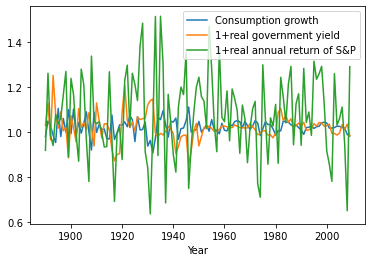

In [159]:
graph=data.rename(columns={"ct+1/ct":"Consumption growth",
                    "R0_t+1":"1+real government yield",
                    "R1_t+1":"1+real annual return of S&P"}) 
graph.plot()


In [160]:
#Set the number of lags

l=1
N=data.shape[1] - 1  #Number of assets
T=data.shape[0] 
params=np.array([1,0])

In [161]:
#Define the moment conditions for every time t

def h_t(t,params,l):
    X=data.iloc[t].to_numpy()
    delta=params[0]
    alpha=params[1]
    E1=delta*X[1]*X[0]**-alpha-1
    E2=delta*X[2]*X[0]**-alpha-1
    Epsilon=np.array([E1,E2])#.reshape(N,1)
    
    Z = np.ones(1)
    for i in range(1, l+1):
        Z = hstack ((Z, data.iloc[t-i].to_numpy() ))
    
    Z.reshape(1+l*(N+1),1)
    h_t=np.kron(Z,Epsilon)
    return h_t

In [162]:
#Group the time series of h_t into a big matrix

def h_t_v2(params,l):
    Z=h_t(0,params,l)
    for i in range(1, T):
        Z = np.vstack((Z,h_t(i,params,l)))
    return Z

In [163]:
#Take the sample Time-mean of each monent condition

def g_T_v2(params,l):
    g_T=np.mean(h_t_v2(params,l),axis=0)
    return g_T
    
        

In [164]:
#Define the 1st-step Objective Function

def Q_1_v2(params):
    delta=params[0]
    alpha=params[1]
    Wt=np.eye(len(g_T_v2(params,l)))
    Q_1=g_T_v2(params,l).dot(Wt).dot(g_T_v2(params,l).T)
    return Q_1

In [165]:
#Minimise the Objective Function

# generate random integer values
from numpy.random import seed
# seed random number generator
seed(1)

# generate random parameters
dim=20
delta_floor=0.5
delta_cap=1.5
alpha_floor=0
alpha_cap=1
params_random=np.random.uniform([delta_floor,alpha_floor], [delta_cap,alpha_cap], [dim,2])

optimization_results=[]
n=1
for i in params_random:
    print(n)
    params=np.array([i[0], i[1]])
    startingVals=params
    step1opt = fmin_bfgs(Q_1_v2, x0=startingVals, full_output=True, maxiter=1000)
#     print(step1opt)
    optimization_results.append(pd.Series([step1opt[0][0], step1opt[0][1], step1opt[1]]))
    n+=1
    print("delta={}, alpha={}".format(step1opt[0][0], step1opt[0][1]))

1
Optimization terminated successfully.
         Current function value: 0.006379
         Iterations: 21
         Function evaluations: 69
         Gradient evaluations: 23
delta=0.9979817677667883, alpha=2.3927139735734784
2
Optimization terminated successfully.
         Current function value: 0.006379
         Iterations: 20
         Function evaluations: 69
         Gradient evaluations: 23
delta=0.9979849190456003, alpha=2.392867177597479
3
Optimization terminated successfully.
         Current function value: 0.006379
         Iterations: 20
         Function evaluations: 69
         Gradient evaluations: 23
delta=0.9979844371914456, alpha=2.3928429305729084
4
Optimization terminated successfully.
         Current function value: 0.006379
         Iterations: 20
         Function evaluations: 69
         Gradient evaluations: 23
delta=0.997984650458977, alpha=2.3928529735877078
5
Optimization terminated successfully.
         Current function value: 0.006379
         Iterations:

In [166]:
optimization_results=pd.concat(optimization_results, axis=1).T.rename(columns={0:"delta", 1:"alpha", 2:"objective_func"}).sort_values(by="objective_func", ascending=True)

optimization_results.sort_values(by="objective_func", ascending=True)

,delta,alpha,objective_func
18,0.997985,2.392875,0.006379
1,0.997985,2.392867,0.006379
16,0.997985,2.392858,0.006379
10,0.997985,2.392864,0.006379
3,0.997985,2.392853,0.006379
7,0.997985,2.392870,0.006379
9,0.997984,2.392845,0.006379
2,0.997984,2.392843,0.006379
19,0.997985,2.392863,0.006379
13,0.997984,2.392825,0.006379


<AxesSubplot:xlabel='delta', ylabel='alpha'>

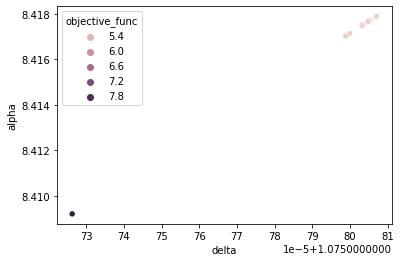

In [88]:
sns.scatterplot(data=optimization_results, x="delta", y="alpha", hue="objective_func")

In [167]:
#Display the 1st-step estimated parameters

Theta_hat_1=np.array(optimization_results.iloc[0,[0,1]])
Theta_hat_1


array([0.99798503, 2.39287452])

In [100]:
## Newey West Matrix

In [168]:
#Gamma_0,T

x = reshape(h_t(0,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T):
    x = np.add(x,reshape(h_t(i,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l))))
x=x
Gamma_0=x/T
Gamma_0

array([[0.01318132, 0.00849196, 0.01326625, 0.0085851 , 0.01373514,
        0.00891591, 0.01382214, 0.00900875],
       [0.00849196, 0.04120813, 0.0085851 , 0.04175845, 0.00891591,
        0.04271553, 0.00900875, 0.04227259],
       [0.01326625, 0.0085851 , 0.01337598, 0.00869491, 0.01380368,
        0.00899919, 0.0139446 , 0.00912753],
       [0.0085851 , 0.04175845, 0.00869491, 0.04240398, 0.00899919,
        0.04321391, 0.00912753, 0.04291462],
       [0.01373514, 0.00891591, 0.01380368, 0.00899919, 0.01437802,
        0.00940397, 0.01429027, 0.00937717],
       [0.00891591, 0.04271553, 0.00899919, 0.04321391, 0.00940397,
        0.04443901, 0.00937717, 0.04375277],
       [0.01382214, 0.00900875, 0.0139446 , 0.00912753, 0.01429027,
        0.00937717, 0.01531885, 0.01014053],
       [0.00900875, 0.04227259, 0.00912753, 0.04291462, 0.00937717,
        0.04375277, 0.01014053, 0.04513417]])

In [169]:
#Gamma_1,T

x = reshape(h_t(1,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T-1):
    x = np.add(x,reshape(h_t(i+1,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l))))
x=x
Gamma_1=x/T
Gamma_1

array([[ 0.0022762 , -0.01079768,  0.0023049 , -0.01084298,  0.00222436,
        -0.01135965,  0.00224226, -0.01080539],
       [ 0.00325945, -0.00598219,  0.00324947, -0.00589873,  0.00344854,
        -0.00611279,  0.00265642, -0.00665969],
       [ 0.00228202, -0.0107088 ,  0.00231746, -0.01075827,  0.00222517,
        -0.01125449,  0.00226672, -0.01075379],
       [ 0.00311432, -0.00601891,  0.0031224 , -0.00593071,  0.00327606,
        -0.00614839,  0.00260531, -0.00669733],
       [ 0.00256827, -0.01127536,  0.00259059, -0.01132527,  0.00253394,
        -0.01186115,  0.00249906, -0.01128188],
       [ 0.0037877 , -0.00602967,  0.00376416, -0.00595183,  0.00402499,
        -0.006136  ,  0.00305178, -0.00677643],
       [ 0.00165899, -0.0130722 ,  0.00170968, -0.01314962,  0.00153524,
        -0.01370004,  0.00175846, -0.01310369],
       [ 0.00300105, -0.00537197,  0.00301665, -0.00516555,  0.00314875,
        -0.005575  ,  0.00255759, -0.00617746]])

In [170]:
#Gamma_2,T

x = reshape(h_t(2,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T-2):
    x = np.add(x,reshape(h_t(i+2,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l))))
x=x
Gamma_2=x/T
Gamma_2

array([[ 1.83867268e-03,  8.27065354e-04,  1.83917361e-03,
         9.15492700e-04,  1.94138754e-03,  7.19717913e-04,
         2.21103229e-03,  1.48185350e-03],
       [-1.29358272e-04, -3.81902269e-03, -2.28140242e-04,
        -3.93168873e-03,  2.56621551e-05, -3.83840738e-03,
        -3.94765056e-04, -2.87489072e-03],
       [ 1.91232922e-03,  8.37368602e-04,  1.91310194e-03,
         9.22499719e-04,  2.02112839e-03,  7.39687667e-04,
         2.28847267e-03,  1.51495427e-03],
       [-1.19659751e-04, -3.67172667e-03, -2.07634654e-04,
        -3.80481773e-03,  2.77113969e-05, -3.64795311e-03,
        -3.83229188e-04, -2.73530787e-03],
       [ 1.86774351e-03,  7.05182724e-04,  1.86694667e-03,
         7.85379509e-04,  1.98114067e-03,  5.89217371e-04,
         2.20601902e-03,  1.37198639e-03],
       [ 1.12340716e-05, -4.14390383e-03, -9.85552073e-05,
        -4.24621924e-03,  1.90241525e-04, -4.19445123e-03,
        -3.11741742e-04, -3.15365993e-03],
       [ 1.48393714e-03,  8.425823

In [171]:
#Gamma_3,T

x = reshape(h_t(3,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(0,Theta_hat_1,l),(1,N+N*(N+1)*l)))
for i in range(1,T-3):
    x = np.add(x,reshape(h_t(i+3,Theta_hat_1,l),(N+N*(N+1)*l,1)).dot(reshape(h_t(i,Theta_hat_1,l),(1,N+N*(N+1)*l))))
x=x
Gamma_3=x/T
Gamma_3

array([[ 0.00067702,  0.00062723,  0.00075127,  0.00081104,  0.00049782,
         0.00055762,  0.00147118,  0.00133736],
       [-0.00065714,  0.00445507, -0.00069262,  0.00449247, -0.00048429,
         0.00465606, -0.00107031,  0.00468158],
       [ 0.00066602,  0.000513  ,  0.00074075,  0.00070567,  0.00047828,
         0.00043491,  0.00147533,  0.00123163],
       [-0.00077183,  0.00468521, -0.00081789,  0.0047288 , -0.00060327,
         0.00489519, -0.00118525,  0.00497558],
       [ 0.00065608,  0.00080093,  0.00073174,  0.00098735,  0.00047653,
         0.00073245,  0.00143557,  0.0015146 ],
       [-0.00052946,  0.00448975, -0.00055327,  0.00453293, -0.00033749,
         0.00468844, -0.00096827,  0.00467728],
       [ 0.00096421,  0.00047344,  0.00105303,  0.00069097,  0.00076555,
         0.00037232,  0.00186924,  0.00119415],
       [-0.00036611,  0.00601856, -0.00038358,  0.00606446, -0.00021956,
         0.00634375, -0.00048088,  0.00660698]])

In [172]:
NW=Gamma_0+0.75*(Gamma_1+Gamma_1.T)+0.50*(Gamma_2+Gamma_2.T)+0.25*(Gamma_3+Gamma_3.T)
NW

array([[0.0187728 , 0.00317966, 0.01893651, 0.00319633, 0.01952265,
        0.00360946, 0.01920441, 0.00385512],
       [0.00317966, 0.03064336, 0.00325031, 0.03131293, 0.00349038,
        0.03190398, 0.00127161, 0.03222796],
       [0.01893651, 0.00325031, 0.01913564, 0.00329738, 0.01966204,
        0.00367241, 0.01944066, 0.0039785 ],
       [0.00319633, 0.03131293, 0.00329738, 0.0320675 , 0.00346484,
        0.03254869, 0.00136944, 0.0331069 ],
       [0.01952265, 0.00349038, 0.01966204, 0.00346484, 0.02039834,
        0.00401533, 0.01973466, 0.00404374],
       [0.00360946, 0.03190398, 0.00367241, 0.03254869, 0.00401533,
        0.03338478, 0.00144394, 0.03336431],
       [0.01920441, 0.00127161, 0.01944066, 0.00136944, 0.01973466,
        0.00144394, 0.02103982, 0.00294293],
       [0.00385512, 0.03222796, 0.0039785 , 0.0331069 , 0.00404374,
        0.03336431, 0.00294293, 0.03571125]])

In [173]:
#Define the 2nd-step Objective Function, with Newey West weighting matrix

def Q_2_v2(params):
    delta=params[0]
    alpha=params[1]
    Q_2=g_T_v2(params,l).dot(np.linalg.inv(NW)).dot(g_T_v2(params,l).T)
    return Q_2

In [174]:
#Minimise the Objective Function

# generate random integer values
from numpy.random import seed
# seed random number generator
seed(1)

# generate random parameters
dim=20
delta_floor=0.5
delta_cap=1.5
alpha_floor=0
alpha_cap=1
params_random=np.random.uniform([delta_floor,alpha_floor], [delta_cap,alpha_cap], [dim,2])

optimization_results=[]
n=1
for i in params_random:
    print(n)
    params=np.array([i[0], i[1]])
    startingVals=params
    step1opt = fmin_bfgs(Q_2_v2, x0=startingVals, full_output=True, maxiter=1000)
#     print(step1opt)
    optimization_results.append(pd.Series([step1opt[0][0], step1opt[0][1], step1opt[1]]))
    n+=1
    print("delta={}, alpha={}".format(step1opt[0][0], step1opt[0][1]))

1
Optimization terminated successfully.
         Current function value: 0.094219
         Iterations: 7
         Function evaluations: 33
         Gradient evaluations: 11
delta=0.9834583722193152, alpha=0.9749529536088583
2
Optimization terminated successfully.
         Current function value: 0.094219
         Iterations: 6
         Function evaluations: 27
         Gradient evaluations: 9
delta=0.9834583971159615, alpha=0.9749527174893122
3
Optimization terminated successfully.
         Current function value: 0.094219
         Iterations: 7
         Function evaluations: 30
         Gradient evaluations: 10
delta=0.9834586803121885, alpha=0.9749686062932709
4
Optimization terminated successfully.
         Current function value: 0.094219
         Iterations: 6
         Function evaluations: 27
         Gradient evaluations: 9
delta=0.9834586241716919, alpha=0.9749634060406517
5
Optimization terminated successfully.
         Current function value: 0.094219
         Iterations: 6
 

In [175]:
optimization_results=pd.concat(optimization_results, axis=1).T.rename(columns={0:"delta", 1:"alpha", 2:"objective_func"}).sort_values(by="objective_func", ascending=True)

optimization_results.sort_values(by="objective_func", ascending=True)

,delta,alpha,objective_func
9,0.983458,0.974958,0.094219
4,0.983458,0.974958,0.094219
7,0.983458,0.974954,0.094219
12,0.983458,0.974956,0.094219
14,0.983458,0.974957,0.094219
1,0.983458,0.974953,0.094219
0,0.983458,0.974953,0.094219
19,0.983459,0.974961,0.094219
15,0.983459,0.974961,0.094219
3,0.983459,0.974963,0.094219


In [176]:

Theta_hat_2=np.array(optimization_results.iloc[0,[0,1]])
Theta_hat_2


array([0.9834585 , 0.97495812])

In [458]:
##Covariance Matrix of Theta



In [99]:
# Matrix Jacobian of g_T , computed numerically by incrementing marginally the estimators by Incr
Incr=0.01
Theta_d1=array((Theta_hat_2[0]+Incr,Theta_hat_2[1]))
Theta_d2=array((Theta_hat_2[0],Theta_hat_2[1]+Incr))
DT_1=(g_T_v2(Theta_d1,l)-g_T_v2(Theta_hat_2,l))/Incr
DT_2=(g_T_v2(Theta_d2,l)-g_T_v2(Theta_hat_2,l))/Incr
DT=np.vstack((DT_1,DT_2))
DT


array([[ 0.91447976,  0.96240646,  0.93328649,  0.98154491,  0.93486464,
         0.98439126,  0.95783171,  1.01029344,  0.93270092,  0.98169308,
         0.93291103,  0.98082751,  0.98281377,  1.02773029,  0.93439003,
         0.9833923 ,  0.93371041,  0.98181663,  0.99033174,  1.04281132,
         0.93335266,  0.98204478,  0.93387757,  0.98324729,  0.99470674,
         1.04386748,  0.93356771,  0.98277782,  0.93304353,  0.98267311,
         0.98935477,  1.03738712,  0.93321416,  0.98228712,  0.93037834,
         0.97838601,  0.98764011,  1.04093212],
       [-0.00959581, -0.01074392, -0.00989449, -0.01105896, -0.00934519,
        -0.01054118, -0.01402349, -0.01532838, -0.00991731, -0.01104045,
        -0.00960194, -0.0107945 , -0.01095877, -0.01231363, -0.00966058,
        -0.01079895, -0.00949068, -0.01066991, -0.00949881, -0.01087609,
        -0.00985229, -0.0110261 , -0.00941675, -0.0106316 , -0.0087024 ,
        -0.00990127, -0.00981516, -0.0109508 , -0.00957392, -0.01070778,
   

In [476]:
#Variance Covariance Matrix of the Estimators

In [100]:
(np.linalg.inv((DT).dot(np.linalg.inv(NW)).dot(DT.T)))/T

array([[5.18688069e-04, 1.58825018e-02],
       [1.58825018e-02, 9.06828739e-01]])